In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:33699 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 96.00 GiB


In [3]:
session = cc.database.create_session()

In [4]:
exptdict = OrderedDict([
    ('01deg_IAF_Kv09',   {'expt':'01deg_jra55v140_iaf_KvJ09','dir':'access-om2-01'}),
    ('01deg_IAF_cycle1',  {'expt':'01deg_jra55v140_iaf','dir':'access-om2-01'}),
    ('01deg_IAF_cycle2',  {'expt':'01deg_jra55v140_iaf_cycle2','dir':'access-om2-01'})
                        ])

## Scalar diagnostics

In [5]:
def plot_timeseries(variable):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,chunks={"time":None})
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 18.9 s, sys: 2.26 s, total: 21.2 s
Wall time: 35.1 s


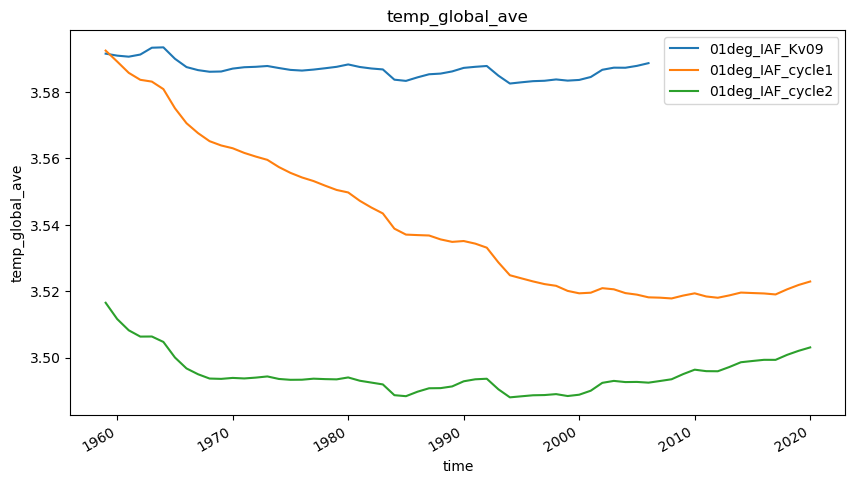

In [6]:
%%time
plot_timeseries('temp_global_ave')

### Global Average Salinity

CPU times: user 20.2 s, sys: 1.99 s, total: 22.2 s
Wall time: 31.3 s


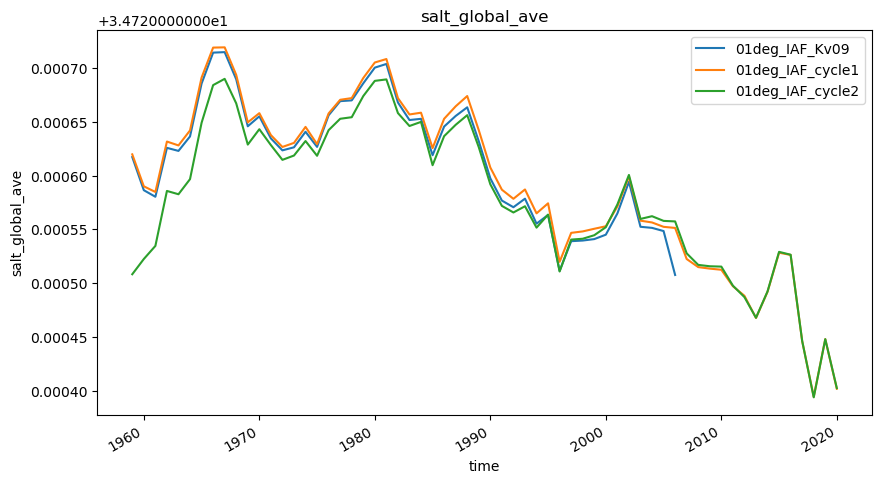

In [7]:
%%time
plot_timeseries('salt_global_ave')

### Surface Temperature

CPU times: user 20.3 s, sys: 2 s, total: 22.3 s
Wall time: 31.2 s


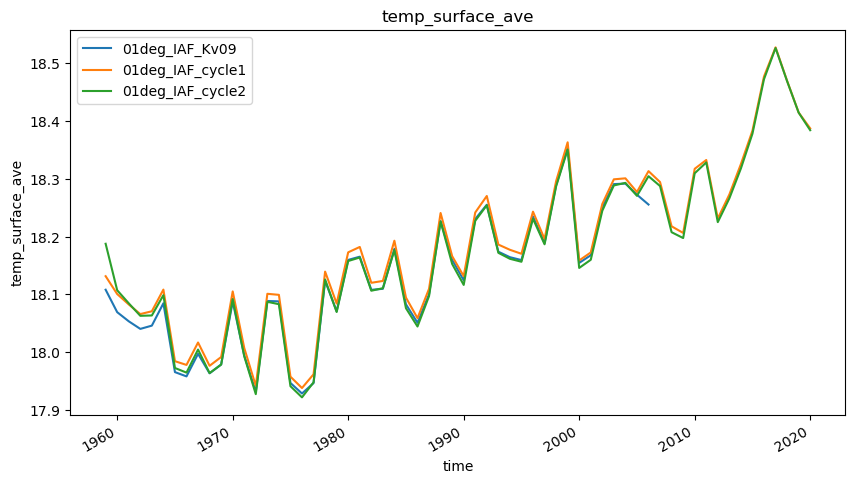

In [8]:
%%time
plot_timeseries('temp_surface_ave')

### Surface Salinity

CPU times: user 20.4 s, sys: 1.94 s, total: 22.4 s
Wall time: 31.3 s


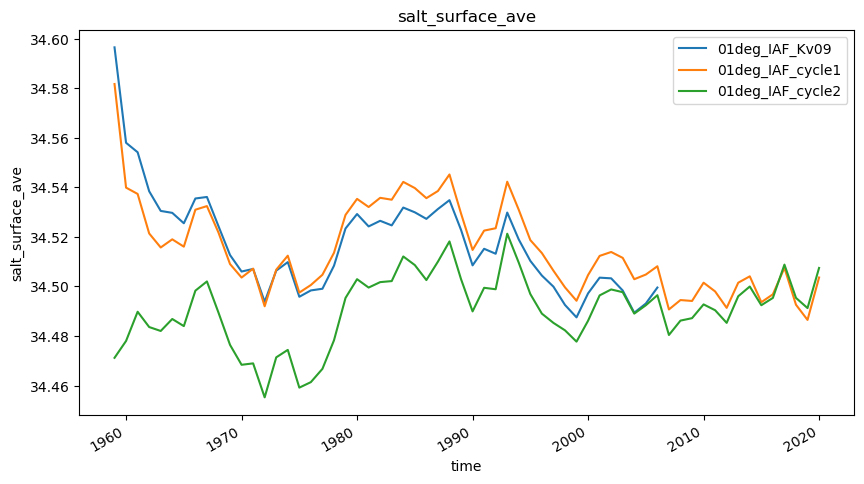

In [9]:
%%time
plot_timeseries('salt_surface_ave')

### Total Kinetic Energy

CPU times: user 20.2 s, sys: 1.89 s, total: 22 s
Wall time: 31.2 s


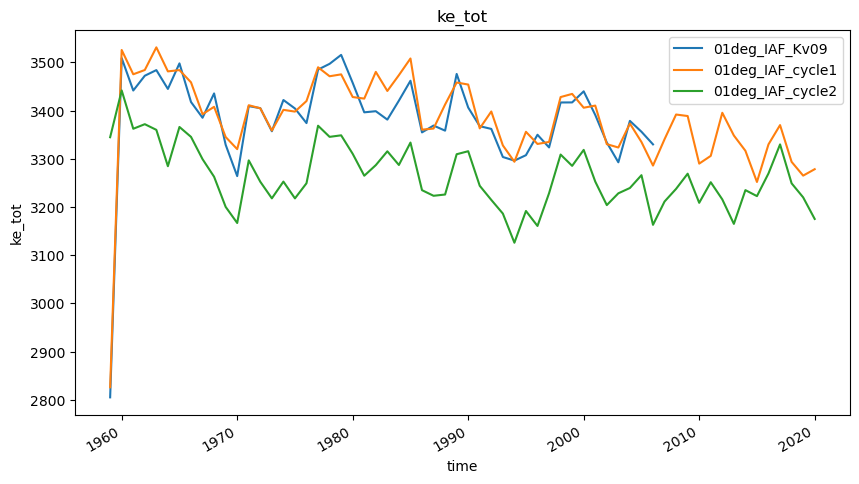

In [10]:
%%time
plot_timeseries('ke_tot')

## Circulation Diagnostics

### Drake Passage Transport

01deg_jra55v140_iaf_KvJ09
01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2
CPU times: user 24.4 s, sys: 2.28 s, total: 26.7 s
Wall time: 46.9 s


Text(0.5, 1.0, 'ACC Transport')

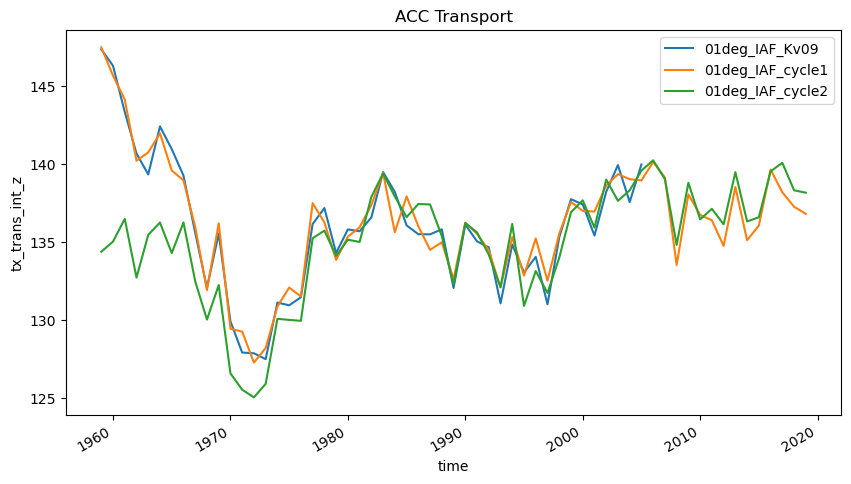

In [11]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,chunks={"time":None,"grid_yu_ocean":2700,"grid_xt_ocean":100})
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

01deg_jra55v140_iaf_KvJ09
01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2
CPU times: user 4min 48s, sys: 20.4 s, total: 5min 9s
Wall time: 20min 10s


Text(0.5, 1.0, 'AABW Cell')

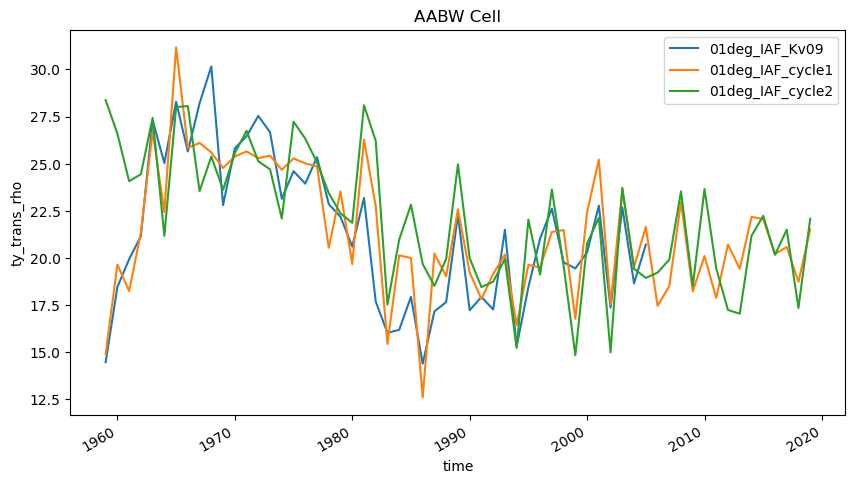

In [12]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,chunks={"time":None,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600})
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

01deg_jra55v140_iaf_KvJ09
01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2
CPU times: user 3min 17s, sys: 13.1 s, total: 3min 30s
Wall time: 11min 16s


Text(0.5, 1.0, 'AMOC Cell')

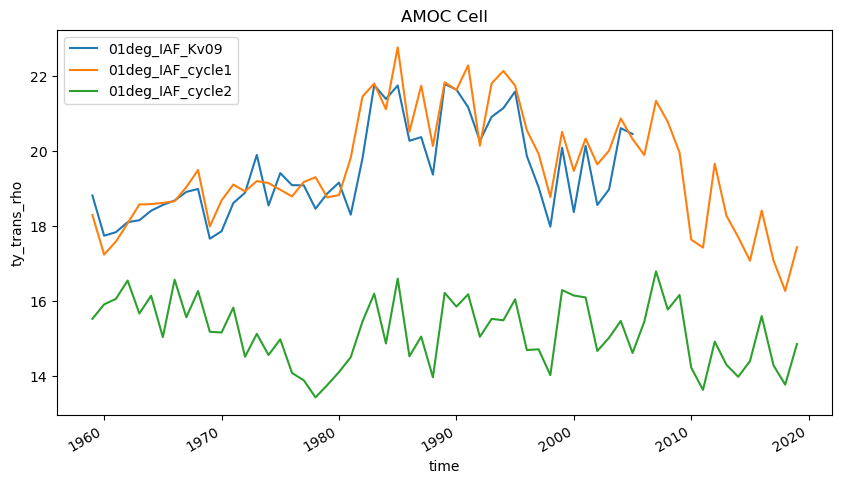

In [13]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,chunks={"time":None,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600})
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

## Global Overturning Streamfunction

In [28]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

01deg_jra55v140_iaf_KvJ09
01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2


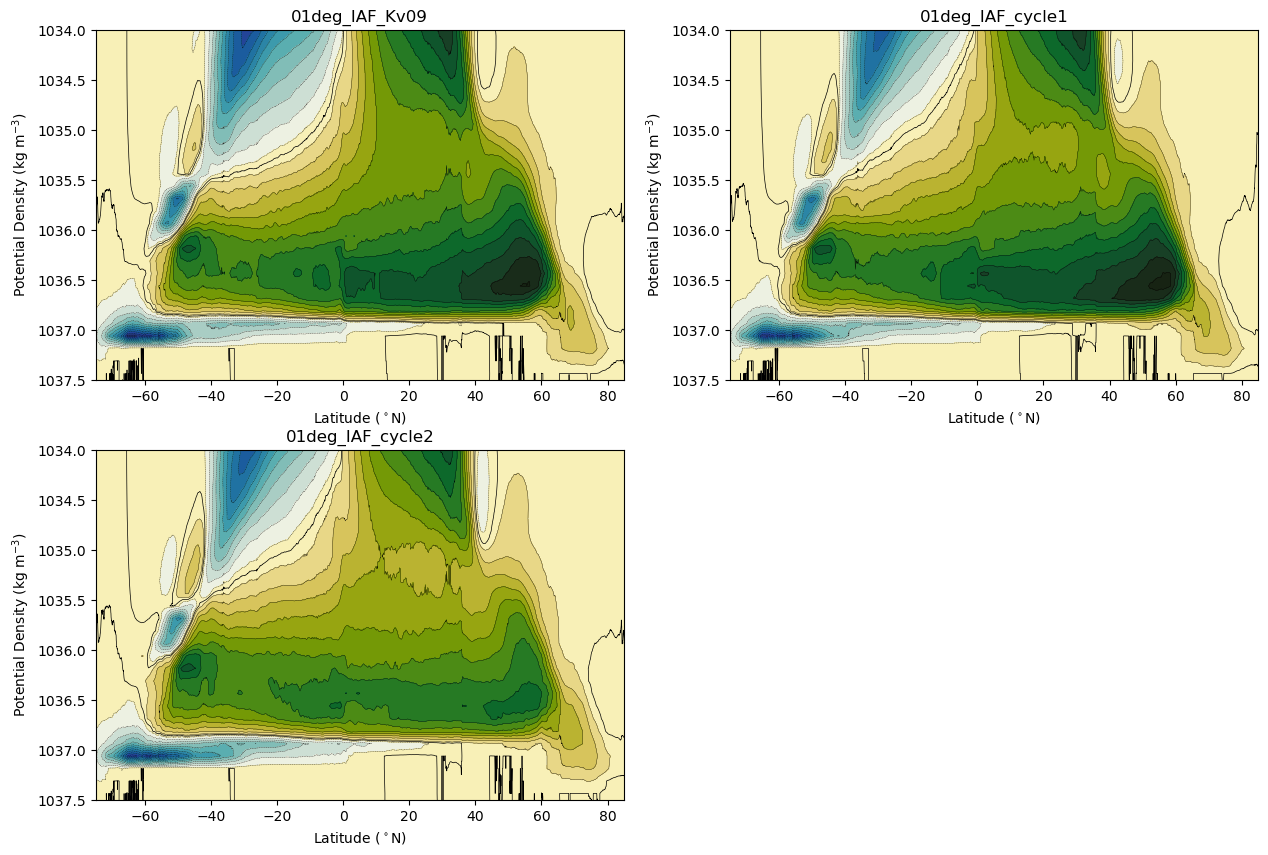

In [29]:
plt.figure(figsize=(15,10))
variable='ty_trans_rho'
ii=0
for ekey in exptdict.keys():
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,start_time='1995-01-01',end_time='2003-12-31')
    psi = var.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)



### Ice Area (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

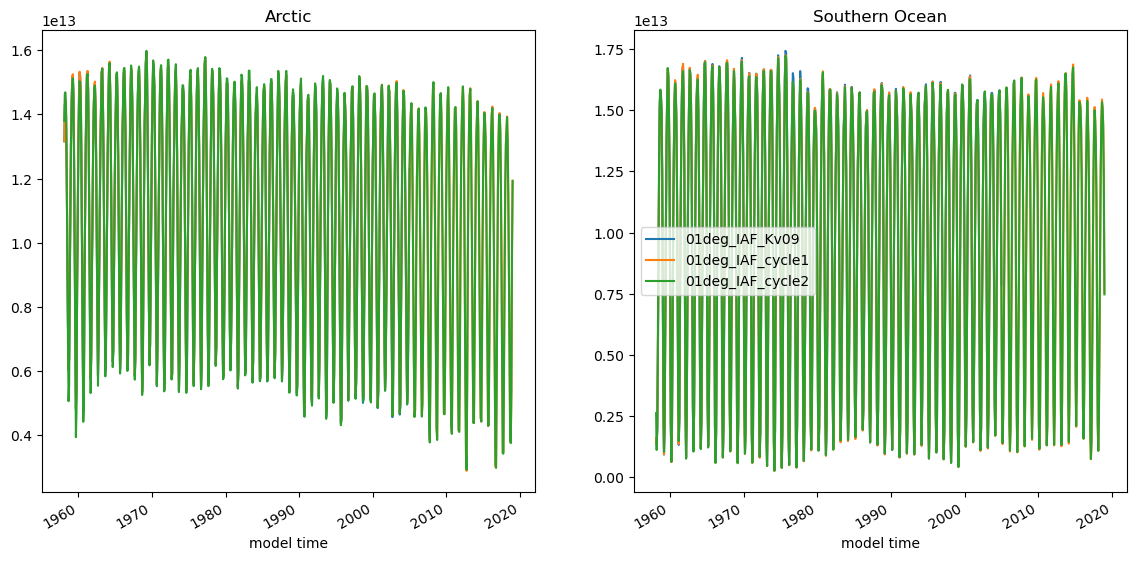

In [30]:
variable='aice_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

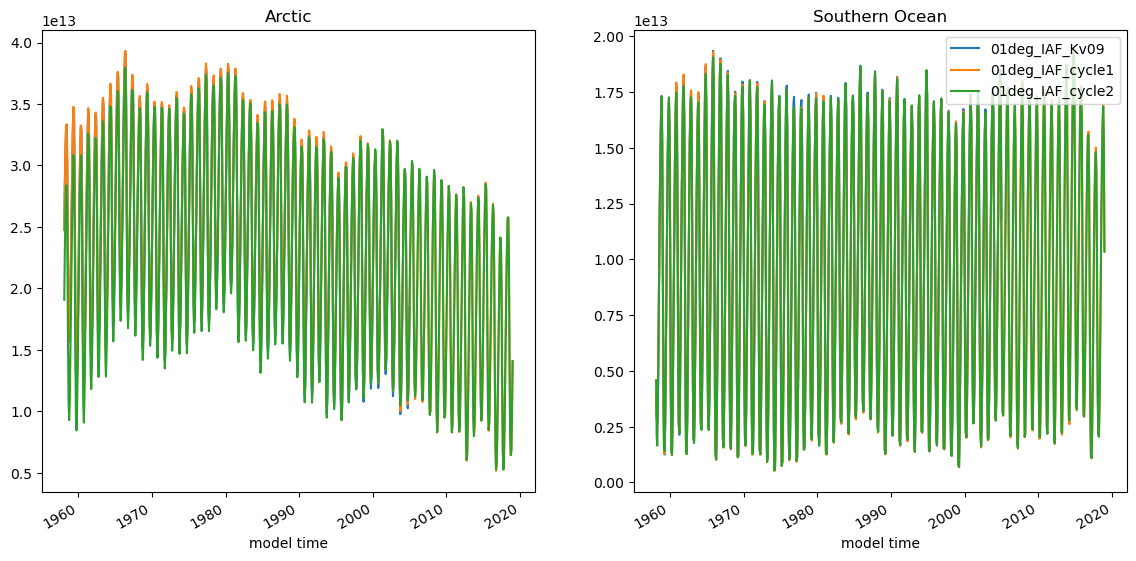

In [31]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')